In [1]:
######################################################
#
# ReaSCAN: on the mission for AGI with language.
#
# Author: Zhengxuan Wu (wuzhengx@stanford.edu)
#
# Descriptions:
# This script is used as initial plannings for the 
# ReaSCAN engine. It illustrate how to integrate different
# parts together, such as Mini-Grid gym etc..
#
# Notes:
# 1. We will leverage gSCAN core engines but with extensive 
# modifications for ReaSCAN. This ensures fairness of 
# comparisions.
######################################################

In [2]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *

### Vocabulary Module

In [3]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [4]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [5]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [6]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

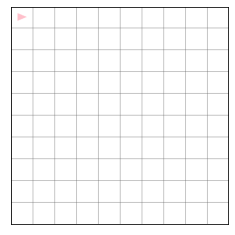

In [7]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'
world = World(grid_size=10, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world_rgb = world.render_simple()

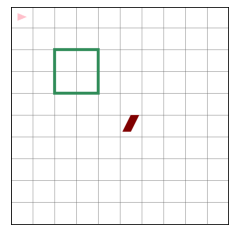

In [8]:
# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=5, column=5))
_ = world.render_simple()

### ReaSCAN Grammer Module

In [9]:
grammer = Grammer(vocabulary)

In [10]:
grammer._sample_grammer_pattern_reascan_train()

['$OBJ_0 ^ $OBJ_1', '$OBJ_0 ^ $OBJ_1 & $OBJ_2', '$OBJ_0 ^ $OBJ_1 ^ $OBJ_2']

In [11]:
grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2 ^ $OBJ_3 & $OBJ_4')

OrderedDict([('$OBJ_0', ['$OBJ_1', '$OBJ_2']),
             ('$OBJ_2', ['$OBJ_3', '$OBJ_4'])])

In [12]:
grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2'))[:5]

[({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLUMN')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$IS_INSIDE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_SIZE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLOR')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_COLUMN'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_ROW')]))]

In [13]:
obj_pattern_map = {'$OBJ_0': '$SHAPE', '$OBJ_1': '$SIZE $SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$SAME_COLUMN'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)

[{'$OBJ_0': 'circle', '$OBJ_1': 'big circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'big circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'big cylinder', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'big cylinder', '$OBJ_2': 'square'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'big square', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'big square', '$OBJ_2': 'square'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'small circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'small circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'small cylinder', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'small cylinder', '$OBJ_2': 'square'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'small square', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'circle', '$OBJ_1': 'small square', '$OBJ_2': 'square'},
 {'$OBJ_0': 'cylinder', '$OBJ_1': 'big circle', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'cylinder', '$OBJ_1': 'big circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'cylinder', '$

### ReaSCAN Simulator

In [14]:
# Valid (covers uniqueness as well)
# Necessary (all relations in the command are needed)
# Distracting

In [107]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *

class Simulator(object):
    """
    This convert generated grammers into a world/situation.
    
    Sample Situation:
    Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
              target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                             position=Position(row=10, column=4),
                                             vector=np.array([1, 0, 1])),
              placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                               position=Position(row=10, column=4),
                                               vector=np.array([1, 0, 1])),
                              PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                               position=Position(row=3, column=12),
                                               vector=np.array([0, 1, 0]))], carrying=None)
                                               
    Sample Placement in the World:
    world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
    
    """
    def __init__(self, object_vocabulary, vocabulary, grid_size=15, 
                 n_object_min=6,
                 n_object_max=12,
                 save_directory="./tmp/"):
        self.object_vocabulary = object_vocabulary
        self.vocabulary = vocabulary
        self.grid_size = grid_size
        self.n_object_min = n_object_min
        self.n_object_max = n_object_max

        self._world = World(grid_size=grid_size, colors=vocabulary.get_semantic_colors(),
                            object_vocabulary=object_vocabulary,
                            shapes=vocabulary.get_semantic_shapes(),
                            save_directory=save_directory)
        self._world.clear_situation()
    
    def sample_object_shape(
        self, obj_grammer, obj_pattern, obj_str, rel_map, 
        is_root, shape_map
    ):
        obj_pattern = obj_pattern.split(" ")
        obj_str = obj_str.split(" ")
        shape = None
        if len(obj_str) == 3:
            shape = obj_str[2]
        elif len(obj_str) == 2:
            shape = obj_str[1]
        elif len(obj_str) == 1:
            # it must be the object
            shape = obj_str[0]
        # Final handling for the shape.
        if shape == "object":
            shape = self.object_vocabulary.sample_shape()
            
        # Override size, color and shape based on relations.
        if not is_root:
            # Go through the rel.
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in shape_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_SHAPE":
                            shape = shape_map[pair[0]]
                        elif rel == "$IS_INSIDE":
                            shape = "box"
        return shape
    
    def sample_object_spec(
        self, obj_grammer, obj_pattern, obj_str, rel_map, 
        is_root, obj_placed_map, 
        size_restriction_map=None
    ):
        obj_pattern = obj_pattern.split(" ")
        obj_str = obj_str.split(" ")
        color = None
        size = None
        shape = None
        if len(obj_str) == 3:
            size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
            color = obj_str[1]
            shape = obj_str[2]
        elif len(obj_str) == 2:
            if "$COLOR" in obj_pattern: # color + shape.
                size = self.object_vocabulary.sample_size()
                color = obj_str[0]
                shape = obj_str[1]
            elif "$SIZE" in obj_pattern: # size + shape.
                size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
                color = self.object_vocabulary.sample_color()
                shape = obj_str[1]
        elif len(obj_str) == 1:
            # it must be the object
            size = self.object_vocabulary.sample_size()
            color = self.object_vocabulary.sample_color()
            shape = obj_str[0]
        # Final handling for the shape.
        if shape == "object":
            shape = self.object_vocabulary.sample_shape()
            
        # Override size, color and shape based on relations.
        if not is_root:
            # Go through the rel.
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in obj_placed_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_SHAPE":
                            shape = obj_placed_map[pair[0]].shape
                        elif rel == "$SAME_COLOR":
                            color = obj_placed_map[pair[0]].color
                        elif rel == "$SAME_SIZE":
                            size = obj_placed_map[pair[0]].size
                        elif rel == "$IS_INSIDE":
                            shape = "box" # Might never reach here.
        return Object(color=color,size=size,shape=shape)
                    
    def sample_object_position(
        self, sampled_obj, root, obj_grammer, 
        rel_map, obj_placed_map, 
        obj_position_map,
        retry_max=10
    ):
        # If it is the first node, we directly return.
        if obj_grammer == root:
            sampled_pos = self._world.sample_position()
            return sampled_pos
                
        for _ in range(retry_max):
            obj_random_pos = self._world.sample_position()
            row = obj_random_pos.row
            col = obj_random_pos.column
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in obj_placed_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_ROW":
                            row = obj_position_map[pair[0]].row
                        elif rel == "$SAME_COLUMN":
                            col = obj_position_map[pair[0]].column
                        elif rel == "$IS_INSIDE":
                            # we need to make sure enclosure
                            size = sampled_obj.size
                            row_higher = min(obj_position_map[pair[0]].row, self.grid_size-size)
                            col_higher = min(obj_position_map[pair[0]].column, self.grid_size-size)
                            row_lower = max(obj_position_map[pair[0]].row-(size-1), 0)
                            col_lower = max(obj_position_map[pair[0]].column-(size-1), 0)
                            random_positions = []
                            for i in range(row_lower, row_higher+1):
                                for j in range(col_lower, col_higher+1):
                                    random_positions.append((i,j))
                            random.shuffle(random_positions)
                            for position in random_positions:
                                # consider the size and boundary as well
                                row = position[0]
                                col = position[1]
                                proposed_position=Position(row=row, column=col)
                                if not self._world.position_taken(proposed_position):
                                    break

            proposed_position=Position(row=row, column=col)
            if sampled_obj.shape != "box":
                if not self._world.position_taken(proposed_position):
                    return proposed_position
            else:
                overlap_box = False
                for obj_str, obj in obj_placed_map.items():
                    if obj.shape == "box":
                        if obj_position_map[obj_str].row == row and \
                            obj_position_map[obj_str].column == col:
                            overlap_box = True
                            break
                if not overlap_box:
                    return proposed_position
        return -1 # Fail to propose a valid position.
    
    def sample_random_object_spec(self, size_exclude=None, 
                                  color_exclude=None, shape_exclude=None):
        d_size = self.object_vocabulary.sample_size(_exclude=size_exclude)
        d_color = self.object_vocabulary.sample_color(_exclude=color_exclude)
        d_shape = self.object_vocabulary.sample_shape(_exclude=shape_exclude)
        return Object(color=d_color,size=d_size,shape=d_shape)
    
    def place_distractor_from_dict(
        self, distractors_dict, 
        obj_placed_map, obj_position_map, 
        debug=False, 
        special_shape_size_bound=None
    ):
        if debug:
            import pprint
            pp = pprint.PrettyPrinter(indent=4)
            pp.pprint(distractors_dict)
        distractor_root = f"$OBJ_{len(obj_placed_map)}"
        success = True
        distractors_obj_map = distractors_dict["obj_map"]
        distractors_rel_map = distractors_dict["rel_map"]
        distractors_obj_pattern_map = distractors_dict["obj_pattern_map"]
        distractors_size_map = distractors_dict["size_map"]
        for dis_grammer, dis_str in distractors_obj_map.items():
            # 1. Sample object.
            sampled_dis = self.sample_object_spec(
                dis_grammer,
                distractors_obj_pattern_map[dis_grammer], 
                dis_str, distractors_rel_map, 
                is_root=dis_grammer==distractor_root, 
                obj_placed_map=obj_placed_map
            )
            # 1.1. Update the size of the object if needed.
            if dis_grammer in distractors_size_map.keys():
                sampled_dis = Object(
                    color=sampled_dis.color,
                    size=distractors_size_map[dis_grammer],
                    shape=sampled_dis.shape
                )
            # 1.2. Another pass of override by using global constraints.
            special_shape_super = sampled_dis.shape
            special_shape_sub = sampled_dis.color + " " + sampled_dis.shape
            # e.g., small circle exists in the command, then any colored circle needs to be constrain
            if special_shape_super in special_shape_size_bound.keys():
                if "small" in dis_str:
                    updated_size = special_shape_size_bound[special_shape_super][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_super][1]
                sampled_dis = Object(
                    color=sampled_dis.color,
                    size=updated_size,
                    shape=sampled_dis.shape
                )
            elif special_shape_sub in special_shape_size_bound.keys():
                if "small" in dis_str:
                    updated_size = special_shape_size_bound[special_shape_sub][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_sub][1]
                sampled_dis = Object(
                    color=sampled_dis.color,
                    size=updated_size,
                    shape=sampled_dis.shape
                )
            else:
                pass # Do nothing.

            # 2. Place on the world map.
            sampled_pos = self.sample_object_position(
                sampled_dis, distractor_root, 
                dis_grammer, distractors_rel_map, 
                obj_placed_map, obj_position_map
            )

            if sampled_dis == -1 or sampled_pos == -1:
                return False

            self._world.place_object(
                sampled_dis, 
                position=sampled_pos, target=False # Distractor is never the target!
            )
            obj_placed_map[dis_grammer] = sampled_dis
            obj_position_map[dis_grammer] = sampled_pos
        return True
    
    def sample_situations_from_grounded_grammer(self, grammer_pattern, 
                                                obj_pattern_map, rel_map, obj_map, root="$OBJ_0", 
                                                is_plot=False, 
                                                include_random_distractor=False, 
                                                include_relation_distractor=False, 
                                                include_size_distractor=False, 
                                                include_isomorphism_distractor=False, 
                                                debug=False):
        # Clear current world.
        self._world.clear_situation()
        
        # Start placing objects with specs.
        obj_placed_map = OrderedDict({})
        obj_position_map = OrderedDict({})
        referred_obj = root
        
        # Preliminary size check!
        """
        Here is a list of potential internal conflicts:
        (1) ... to a small box ... to a yellow box ...
        Explain: we need to adjust the size of two boxes
        so that small box has 1 size, and all other boxes 
        have the same other size.
        There will at max two different size of same type objects.
        
        So this is the rule:
        For 1 type of shape, max two different sizes.
        """
        # Ok, we need to determine shapes first!
        # Even there is any abstract object, the
        # shape is now determined.
        object_map = {}
        for obj_grammer, obj_str in obj_map.items():
            # 1. Sample object.
            sampled_obj = self.sample_object_spec(
                obj_grammer,
                obj_pattern_map[obj_grammer], obj_str, rel_map, 
                is_root=obj_grammer==root, 
                obj_placed_map=object_map
            )
            object_map[obj_grammer] = sampled_obj

        # Then, we will determine size bounds.
        special_shape_size_bound = {}
        for obj_grammer, obj_pattern in obj_pattern_map.items():
            
            small_size = random.randint(
                self.object_vocabulary._min_size, 
                self.object_vocabulary._max_size-1
            )
            big_size = random.randint(
                small_size+1, 
                self.object_vocabulary._max_size
            )
            
            if "$SIZE" in obj_pattern and "$COLOR" in obj_pattern:
                if object_map[obj_grammer].shape in special_shape_size_bound.keys():
                    # e.g., small circle exists
                    special_shape_size_bound[special_shape] = special_shape_size_bound[object_map[obj_grammer].shape]
                else:
                    # e.g., small yellow circle
                    special_shape = object_map[obj_grammer].color + " " + object_map[obj_grammer].shape
                    special_shape_size_bound[special_shape] = [small_size, big_size]
            elif "$SIZE" in obj_pattern:
                # e.g., small circle
                # overwrite any existing bounds.
                special_shape = object_map[obj_grammer].shape
                for ss, bound in special_shape_size_bound.items():
                    if special_shape in ss:
                        special_shape_size_bound[ss] = [small_size, big_size]
                # for shape, it adds.
                special_shape_size_bound[special_shape] = [small_size, big_size]
                # for non-sized shape, it also adds as long as shape is the same.
                for obj_grammer, obj_pattern in obj_pattern_map.items():
                    if special_shape in obj_map[obj_grammer]:
                        if "$COLOR" in obj_pattern:
                            special_shape = object_map[obj_grammer].color + " " + object_map[obj_grammer].shape
                            special_shape_size_bound[special_shape] = [small_size, big_size]
            else:
                continue
        
        # Update object size based on global scanning results.
        updated_object_map = {}
        for obj_grammer, obj_pattern in obj_pattern_map.items():

            special_shape_super = object_map[obj_grammer].shape
            special_shape_sub = object_map[obj_grammer].color + " " + object_map[obj_grammer].shape
            
            # e.g., small circle exists in the command, then any colored circle needs to be constrain
            if special_shape_super in special_shape_size_bound.keys():
                if "small" in obj_map[obj_grammer]:
                    updated_size = special_shape_size_bound[special_shape_super][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_super][1]
                updated_object_map[obj_grammer] = Object(
                    color=object_map[obj_grammer].color,
                    size=updated_size,
                    shape=object_map[obj_grammer].shape
                )
            elif special_shape_sub in special_shape_size_bound.keys():
                if "small" in obj_map[obj_grammer]:
                    updated_size = special_shape_size_bound[special_shape_sub][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_sub][1]
                updated_object_map[obj_grammer] = Object(
                    color=object_map[obj_grammer].color,
                    size=updated_size,
                    shape=object_map[obj_grammer].shape
                )
            else:
                # If nothing exists in the special size map, then we don't need
                # to alter the size.
                updated_object_map[obj_grammer] = object_map[obj_grammer]
        
        # Next, we sample positions of all objects and place them.
        for obj_grammer, obj_str in obj_map.items():
            # 1. Sample object (bu fetching the updated one).
            sampled_obj = updated_object_map[obj_grammer]
            
            # 2. Place on the world map.
            sampled_pos = self.sample_object_position(
                sampled_obj, root, obj_grammer, rel_map, 
                obj_placed_map, obj_position_map
            )
            
            if sampled_obj == -1 or sampled_pos == -1:
                return -1 # Fail to sample.
        
            self._world.place_object(
                sampled_obj, 
                position=sampled_pos, target=obj_grammer==root
            )
            obj_placed_map[obj_grammer] = sampled_obj
            obj_position_map[obj_grammer] = sampled_pos
        
        """
        Calling in this way to create distractors:

        simulator.sample_distractor_grammer_by_relation(
            grammer_pattern, 
            obj_pattern_map, 
            rel_map, 
            obj_map, 
            sampled_world
        )
        """
        temp_sampled_world = {
            "obj_map" : obj_placed_map,
            "pos_map" : obj_position_map,
            "referred_obj" : referred_obj,
            "situation" : copy.deepcopy(self._world.get_current_situation())
        }
        
        # Three types of distractor sampling for different purposes:
        # sample_distractor_grammer_by_relation()
        # - We will edit one leaf node, so that it makes sure
        #   the command is necessary!
        # sample_distractor_grammer_by_size()
        # - Size relatives need to be meaningful. We will add relational
        #   objects to make sure.
        # sample_distractor_grammer_by_isomorphism()
        # - This is to ensure syntax learning.
        
        distractor_switch_map = OrderedDict({
            "relation" : False,
            "size" : False,
            "isomorphism" : False, 
            "random" : False
        })

        """
        Size distractor is ranked with highest priority.
        As if size descriptors such as small and big appear,
        we always need to ground such descriptors using
        other hard and valid distractors.
        
        Rather than global sampling a larger object for "small object",
        we also want to consider relations. We basically
        perturb a object but sample a set of object maintaining
        relations.
        """
        # Include the size distractor.
        if include_size_distractor:
            size_distractors_dicts = self.sample_distractor_grammer_by_size(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                special_shape_size_bound,
                obj_base_count=len(obj_placed_map)
            )
            if len(size_distractors_dicts) == 0:
                pass # Size distractor is not applicable 
            else:
                for i in range(len(size_distractors_dicts)):
                    succeed = self.place_distractor_from_dict(
                        size_distractors_dicts[i], 
                        obj_placed_map, 
                        obj_position_map,
                        debug=debug,
                        special_shape_size_bound=special_shape_size_bound
                        # This is needed as maybe distractors also 
                        # need to be bounded by global constraints.
                    )
                    if succeed:
                        distractor_switch_map["size"] = True # If one time it is true, it is true.
                        for k, v in size_distractors_dicts[i]["obj_pattern_map"].items():
                            obj_pattern_map[k] = v
                    else:
                        return -1 # Maybe this is too restrict? Let us think about it!
        
        """
        Say something about relational distractors...
        """
        # Include the relation distractor.
        if include_relation_distractor:
            relation_distractors_dicts = self.sample_distractor_grammer_by_relation(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                obj_base_count=len(obj_placed_map)
            )
            if len(relation_distractors_dicts) == 0:
                pass # Size distractor is not applicable 
            else:
                succeed = self.place_distractor_from_dict(
                    relation_distractors_dicts[0], 
                    obj_placed_map, 
                    obj_position_map,
                    debug=debug,
                    special_shape_size_bound=special_shape_size_bound
                    # This is needed as maybe distractors also 
                    # need to be bounded by global constraints.
                )
                if succeed:
                    distractor_switch_map["relation"] = True
                    for k, v in relation_distractors_dicts[0]["obj_pattern_map"].items():
                        obj_pattern_map[k] = v

        """
        Say something about relational distractors...
        """
        # Include ths isomorphism-based distractor.
        if include_isomorphism_distractor:
            isomorphism_distractors_dicts = self.sample_distractor_grammer_by_isomorphism(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                obj_base_count=len(obj_placed_map)
            )
            if len(isomorphism_distractors_dicts) == 0:
                pass # Size distractor is not applicable 
            else:
                succeed = self.place_distractor_from_dict(
                    isomorphism_distractors_dicts[0], 
                    obj_placed_map, 
                    obj_position_map,
                    debug=debug,
                    special_shape_size_bound=special_shape_size_bound
                    # This is needed as maybe distractors also 
                    # need to be bounded by global constraints.
                )
                if succeed:
                    distractor_switch_map["isomorphism"] = True
                    for k, v in isomorphism_distractors_dicts[0]["obj_pattern_map"].items():
                        obj_pattern_map[k] = v
                        
        # Place random distractors. These are gSCAN like distractors
        # which are often not very meaningful for testing agents language
        # knowledge. We recommand always turn this off and use other
        # relation-based distractor sampling strategies.
        if include_random_distractor:
            if len(obj_placed_map) >= self.n_object_max:
                pass # Do nothing!
            else:
                n_distractor = random.randint(1, self.n_object_max-len(obj_placed_map))
                core_obj_count = len(obj_placed_map)
                for i in range(0, n_distractor):
                    distractor_idx = core_obj_count+i
                    distractor_name = f"$OBJ_{distractor_idx}"
                    sampled_distractor = self.sample_random_object_spec()
                    sampled_dis_pos = self._world.sample_position()
                    self._world.place_object(
                        sampled_distractor, 
                        position=sampled_dis_pos, target=False
                    )
                    obj_placed_map[distractor_name] = sampled_distractor
                    obj_position_map[distractor_name] = sampled_dis_pos
                distractor_switch_map["random"] = True

        agent_position = self._world.sample_position()
        self._world.place_agent_at(agent_position)
        if is_plot:
            _ = self._world.render_simple()
        
        return {
            "obj_map" : obj_placed_map,
            "pos_map" : obj_position_map,
            "obj_pattern_map" : obj_pattern_map,
            "referred_obj" : referred_obj,
            "situation" : copy.deepcopy(self._world.get_current_situation()), 
            "distractor_switch_map" : distractor_switch_map
        }
    
    def extract_size(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in ["small", "big"]:
                return descriptor
        return ""

    def extract_color(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in self.object_vocabulary.object_colors:
                return descriptor
        return ""
    
    def extract_shape(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in self.object_vocabulary.object_shapes:
                return descriptor
        return ""

    def convert_object_str_to_grammer(self, obj_str):
        size_g = False
        color_g = False
        abs_shape_g = False

        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in ["small", "big"]:
                size_g = True
            elif descriptor in self.object_vocabulary.object_colors:
                color_g = True
            elif descriptor in self.object_vocabulary.object_shapes:
                pass
            elif descriptor == "object":
                abs_shape_g = True

        grammer = []
        if size_g:
            grammer.append("$SIZE")
        if color_g:
            grammer.append("$COLOR")
        if abs_shape_g:
            grammer.append("$ABS_SHAPE") # Mark as deprecated!
        else:
            grammer.append("$SHAPE")
        
        return " ".join(grammer)

    def snap_pattern_to_referent_map(self, distractor_grammer_pattern, base_count):
        distractor_grammer_pattern_snapped = []
        for item in distractor_grammer_pattern.split(" "):
            if item.startswith("$"):
                new_id = int(item.split("_")[1])+base_count
                distractor_grammer_pattern_snapped.append(f"$OBJ_{new_id}")
            else:
                distractor_grammer_pattern_snapped.append(item)
        return " ".join(distractor_grammer_pattern_snapped)

    def snap_object_map_to_referent_map(self, distractor_map, base_count):
        distractor_map_snapped = OrderedDict({})
        for obj_name, item in distractor_map.items():
            new_id = int(obj_name.split("_")[1])+base_count
            new_obj_name = f"$OBJ_{new_id}"
            distractor_map_snapped[new_obj_name] = item
        return distractor_map_snapped

    def snap_relation_map_to_referent_map(self, distractor_rel_map, base_count):
        distractor_rel_map_snapped = OrderedDict({})
        for edge, item in distractor_rel_map.items():
            if edge[0].startswith("$"):
                new_id_left = int(edge[0].split("_")[1])+base_count
                new_obj_name_left = f"$OBJ_{new_id_left}"
            else:
                new_obj_name_left = edge[0]
            
            if edge[1].startswith("$"):
                new_id_right = int(edge[1].split("_")[1])+base_count
                new_obj_name_right = f"$OBJ_{new_id_right}"
            else:
                new_obj_name_right = edge[1]
            distractor_rel_map_snapped[(new_obj_name_left, new_obj_name_right)] = item
        return distractor_rel_map_snapped
    
    def sample_distractor_grammer_by_size(
        self,
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        special_shape_size_bound,
        obj_base_count=0,
    ):
        """
        Our main relation may contains size descriptors such as
        "small" or "big". For these, to make sure they are effectively
        grounded, we need to sample distractors to make sure they 
        are useful in the reasoning.
        
        Currently, we enforce it returns 1. So, across samples, the
        size descriptor needs to be relatively grounded.
        
        small circle -> large circle in any color
        small yellow circle -> large yellow circle
        
        Important Note: Actually, the size of the distractor for each
        shape (color + shape) is almost all pre-determined by our 
        pre-computed size bound. For each shape (color+shape), only 
        two sizes can present. Nothing else. Because, we only have
        simple form of relative descriptors!
        """
        grounded_distractor_grammers = []
        for obj_name, obj_grammer in referent_obj_pattern_map.items():
            if "$SIZE" in obj_grammer:
                # First, let us make copies.
                distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
                distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
                distractor_rel_map = copy.deepcopy(referent_rel_map)
                distractor_obj_map = copy.deepcopy(referent_obj_map)
                # We may need to enforce the size of the distractor due to size descriptors!
                distractor_size_map = OrderedDict({})

                # Second, let us deal with the central object shape
                # Reconstruct its grammer, expressions.
                original_object_str = distractor_obj_map[obj_name]
                original_object = sampled_world['obj_map'][obj_name]
                original_object_size = original_object.size
                if "$COLOR" in obj_grammer:
                    special_shape = \
                        sampled_world['obj_map'][obj_name].color + \
                        " " + sampled_world['obj_map'][obj_name].shape
                else:
                    special_shape = sampled_world['obj_map'][obj_name].shape
                if "small" in original_object_str:
                    distractor_size = special_shape_size_bound[special_shape][1]
                elif "big" in original_object_str:
                    distractor_size = special_shape_size_bound[special_shape][0]
                distractor_size_map[obj_name] = distractor_size
                distractor_shape = original_object.shape
                tmp_name = ""
                if "$COLOR" in obj_grammer:
                    distractor_color = original_object.color
                    new_object_grammer = "$SIZE $COLOR $SHAPE" # $SIZE is a must right?
                    tmp_name = distractor_color + " " + distractor_shape
                else:
                    distractor_color = self.object_vocabulary.sample_color()
                    new_object_grammer = "$SIZE $SHAPE"
                    tmp_name = distractor_shape
                if "small" in original_object_str:
                    tmp_name = "big" + " " + tmp_name
                elif "big" in original_object_str:
                    tmp_name = "small" + " " + tmp_name
                else:
                    pass # Not Implemented
                distractor_obj_map[obj_name] = tmp_name
                distractor_obj_pattern_map[obj_name] = new_object_grammer

                # Then, we will also consider other object sizes. Basically,
                # we keep them the same, unless they form SameShape relation
                # with our core object.
                for _obj_name, _obj in sampled_world['obj_map'].items():
                    if _obj_name != obj_name:
                        if (_obj_name, obj_name) in referent_rel_map and \
                            referent_rel_map[(_obj_name, obj_name)] == "SameShape":
                            distractor_size_map[_obj_name] = distractor_size
                        elif (obj_name, _obj_name) in referent_rel_map and \
                            referent_rel_map[(obj_name, _obj_name)] == "SameShape":
                            distractor_size_map[_obj_name] = distractor_size
                        else:
                            distractor_size_map[_obj_name] = _obj.size

                grounded_distractor_grammers.append({
                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                        distractor_grammer_pattern,
                        obj_base_count
                    ),
                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_pattern_map,
                        obj_base_count
                    ),
                    "rel_map" : self.snap_relation_map_to_referent_map(
                        distractor_rel_map,
                        obj_base_count
                    ),
                    "obj_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_map,
                        obj_base_count
                    ),
                    "size_map" : self.snap_object_map_to_referent_map(
                        distractor_size_map,
                        obj_base_count
                    )
                })
                obj_base_count += len(distractor_obj_map)
        return grounded_distractor_grammers
    
    def sample_distractor_grammer_by_relation(
        self, 
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        surgery_operations=["REL_ADJUST", "OBJ_ADJUST"],
        obj_base_count=0
    ):

        # First, let us make copies.
        distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
        distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
        distractor_rel_map = copy.deepcopy(referent_rel_map)
        distractor_obj_map = copy.deepcopy(referent_obj_map)

        # We may need to enforce the size of the distractor due to size descriptors!
        distractor_size_map = {}

        # To have valid distractor, the original relational map must
        # be missing some leaf edges.
        # e.g., A->B->C becomes A'->B (or object with same descriptor as B) 
        # assums arrow represents the same relational type. A' will be 
        # different than A since C is missing.

        leaf_edges = []
        for edge, relation in distractor_rel_map.items():
            is_leaf = True
            for _edge, _relation in distractor_rel_map.items():
                if edge[1] == _edge[0]:
                    is_leaf = False
                    break
            if is_leaf:
                leaf_edges.append(edge)

        # leaf_edges only contains a single pair, we continue to remove it.
        if len(leaf_edges) == 1:
            pass

        # To remove it, we can take the following actions:
        # 1. Change the relation type.
        # 2. Change the leaf node attributes.
        selected_leaf_edge = random.choice(leaf_edges)
        selected_surgery = random.choice(surgery_operations)
        if "box" in distractor_obj_map[selected_leaf_edge[1]] and \
            "$COLOR" not in distractor_obj_pattern_map[selected_leaf_edge[1]]:
            selected_surgery = "REL_ADJUST"

        if selected_surgery == "REL_ADJUST":
            if distractor_rel_map[selected_leaf_edge] == "$IS_INSIDE":
                # We also need to change the leaf object anyway.
                new_rels = set(["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE"])
                # Do we need to further sample relations based on the src node pattern?
                # For example, source node is "yellow circle" in the command, does it
                # make sense to have the $SAME_COLOR relation?
                # Not really! because if it is $SAME_COLOR, it is kind of to confuse the model
                # to avoid the necessity characteristics.
                # However, a counter argument is, it is still a good distractor to have.
                if "$SIZE" in distractor_obj_pattern_map[selected_leaf_edge[0]]:
                    new_rels -= set(["$SAME_SIZE"])
                if "$COLOR" in distractor_obj_pattern_map[selected_leaf_edge[0]]:
                    new_rels -= set(["$SAME_COLOR"])
                if "$SHAPE" in distractor_obj_pattern_map[selected_leaf_edge[0]]:
                    new_rels -= set(["$SAME_SHAPE"])
                new_rel = random.choice(list(new_rels))
            else:
                new_rels = ["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE", "$IS_INSIDE"]
                new_rels = set(new_rels) - set([distractor_rel_map[selected_leaf_edge]])
                new_rel = random.choice(list(new_rels))
                if new_rel == "$IS_INSIDE":
                    shape = "box"
                    distractor_obj_map[selected_leaf_edge[1]] = shape
                    distractor_obj_pattern_map[selected_leaf_edge[1]] = '$SHAPE'
                else:
                    pass
            shape = "object" # This is a quick trick to have the downstream alg determine color size and shape!
            distractor_rel_map[selected_leaf_edge] = new_rel
            distractor_obj_map[selected_leaf_edge[1]] = shape
            distractor_obj_pattern_map[selected_leaf_edge[1]] = '$ABS_SHAPE'
        elif selected_surgery == "OBJ_ADJUST":
            original_object_name = selected_leaf_edge[1]
            original_object_str = distractor_obj_map[original_object_name]
            original_object = sampled_world['obj_map'][original_object_name]
            # Shape color, we can change, I think.
            adjustable_attributes = ["color", "shape"]
            adjust_attribute = random.choice(adjustable_attributes)
            # If the original object does not have color as attribute, sampling on color
            # is highly likely leading to non-unique referent targets.
            
            # The following code is not considering size for purpose!
            # Size-based distractors are taking care in other functions.
            if "$COLOR" not in distractor_obj_pattern_map[original_object_name]:
                adjust_attribute = "shape"
            if "box" in original_object_str:
                adjust_attribute = "color"
            if adjust_attribute == "color":
                new_color = self.object_vocabulary.sample_color(_exclude=[original_object.color])
                new_object_str = new_color + " " + original_object.shape
            elif adjust_attribute == "shape":
                new_shape = self.object_vocabulary.sample_shape(_exclude=[original_object.shape])
                new_object_str = original_object.color + " " + new_shape
            new_object_grammer = "$COLOR $SHAPE"
            distractor_obj_map[original_object_name] = new_object_str
            distractor_obj_pattern_map[original_object_name] = new_object_grammer
        else:
            pass # Not implemented

        # We need to snap this distractors onto the regular relations.
        
        # We need to increment the object counters.
        return [{
                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                        distractor_grammer_pattern,
                        obj_base_count
                    ),
                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_pattern_map,
                        obj_base_count
                    ),
                    "rel_map" : self.snap_relation_map_to_referent_map(
                        distractor_rel_map,
                        obj_base_count
                    ),
                    "obj_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_map,
                        obj_base_count
                    ),
                    "size_map" : self.snap_object_map_to_referent_map(
                        distractor_size_map,
                        obj_base_count
                    )
                }]

    def sample_distractor_grammer_by_isomorphism(
        self,
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        obj_base_count=0,
    ):
        """
        This set of distractors are for learning syntax and grammers.
        If you simply use BoW approach, it will not work because we 
        always instill confusing targets for you with isomorphism of the
        referent graph.

        For example, if the original grounded command is:
        Go to the red square that is inside of the yellow box.

        We can do a isomorphism which is
        Go to the yellow square that is inside of the red box.

        If the model is not understanding the language correctly,
        it will not able to find the referent target correctly.
        """
        # First, let us make copies.
        distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
        distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
        distractor_rel_map = copy.deepcopy(referent_rel_map)
        distractor_obj_map = copy.deepcopy(referent_obj_map)
        # We may need to enforce the size of the distractor due to size descriptors!
        distractor_size_map = {}

        shufflable_objects = []
        for obj_name, obj_str in distractor_obj_map.items():
            obj_descriptors = obj_str.split(" ")
            if len(obj_descriptors) > 1:
                shufflable_objects.append((obj_name, obj_str))
        if len(shufflable_objects) > 2:
            random.shuffle(shufflable_objects)
        shufflable_objects = shufflable_objects[:2]

        if len(shufflable_objects) == 1:
            return [] # We simply don't have enough objects to do this.

        # We will shuffle attributes between two objects.

        # Prepare shufflable materials.
        obj_name_left = shufflable_objects[0][0]
        obj_name_right = shufflable_objects[1][0]
        size_left = self.extract_size(shufflable_objects[0][1])
        size_right = self.extract_size(shufflable_objects[1][1])
        color_left = self.extract_color(shufflable_objects[0][1])
        color_right = self.extract_color(shufflable_objects[1][1])
        shape_left = self.extract_shape(shufflable_objects[0][1])
        shape_right = self.extract_shape(shufflable_objects[1][1])
        
        left_rebuild = []
        right_rebuild = []
        # We don't swap size!
        if size_left != "":
            left_rebuild.append(size_left)
        if size_right != "":
            right_rebuild.append(size_right)

        # If we shuffle color...
        color_shuffled = False
        if random.random() > 0.5:
            tmp = color_left
            color_left = color_right
            color_right = tmp
            color_shuffled = True
        if color_left != "":
            left_rebuild.append(color_left)
        if color_right != "":
            right_rebuild.append(color_right)

        # If we shuffle shape...
        shape_shuffled = False
        if (not color_shuffled and shape_left != "box" and shape_right != "box") or \
            (random.random() > 0.5 and shape_left != "box" and shape_right != "box"):
            tmp = shape_left
            shape_left = shape_right
            shape_right = tmp
            shape_shuffled = True
        if shape_left != "":
            left_rebuild.append(shape_left)
        else:
            left_rebuild.append("object")
        if shape_right != "":
            right_rebuild.append(shape_right)
        else:
            right_rebuild.append("object")
        
        if not color_shuffled and not shape_shuffled:
            return []
                
        left_rebuild = " ".join(left_rebuild)
        right_rebuild = " ".join(right_rebuild)
        left_grammer_rebuild = self.convert_object_str_to_grammer(left_rebuild)
        right_grammer_rebuild = self.convert_object_str_to_grammer(right_rebuild)
        
        distractor_obj_pattern_map[obj_name_left] = left_grammer_rebuild 
        distractor_obj_pattern_map[obj_name_right] = right_grammer_rebuild 
        distractor_obj_map[obj_name_left] = left_rebuild
        distractor_obj_map[obj_name_right] = right_rebuild
        
        return [{
                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                        distractor_grammer_pattern,
                        obj_base_count
                    ),
                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_pattern_map,
                        obj_base_count
                    ),
                    "rel_map" : self.snap_relation_map_to_referent_map(
                        distractor_rel_map,
                        obj_base_count
                    ),
                    "obj_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_map,
                        obj_base_count
                    ),
                    "size_map" : self.snap_object_map_to_referent_map(
                        distractor_size_map,
                        obj_base_count
                    )
                }]
    

In [108]:
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6
)

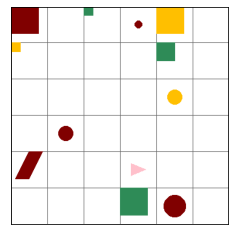

Command:
walk to the square that is in the same column as the red circle and in the same row as the yellow square cautiously


In [109]:
obj_pattern_map = {'$OBJ_0': '$SHAPE', '$OBJ_1': '$COLOR $SHAPE', '$OBJ_2': '$COLOR $SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_COLUMN', ('$OBJ_0', '$OBJ_2'): '$SAME_ROW'}
obj_map = {'$OBJ_0': 'square', '$OBJ_1': 'red circle', '$OBJ_2': 'yellow square'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'

sampled_world = simulator.sample_situations_from_grounded_grammer(
    grammer_pattern, 
    obj_pattern_map, 
    rel_map, 
    obj_map,
    is_plot=True,
    include_size_distractor=True, 
    include_relation_distractor=True, 
    include_isomorphism_distractor=True, 
    include_random_distractor=True,
    debug=False
)

print("Command:")
command_str = grammer.repre_str_command(grammer_pattern, rel_map, obj_map)
print(f"walk to {command_str} cautiously")

In [111]:
sampled_world

{'obj_map': OrderedDict([('$OBJ_0',
               Object(size=2, color='green', shape='square')),
              ('$OBJ_1', Object(size=3, color='red', shape='circle')),
              ('$OBJ_2', Object(size=1, color='yellow', shape='square')),
              ('$OBJ_3', Object(size=3, color='green', shape='square')),
              ('$OBJ_4', Object(size=1, color='red', shape='circle')),
              ('$OBJ_5', Object(size=1, color='green', shape='square')),
              ('$OBJ_6', Object(size=3, color='yellow', shape='square')),
              ('$OBJ_7', Object(size=2, color='yellow', shape='circle')),
              ('$OBJ_8', Object(size=3, color='red', shape='square')),
              ('$OBJ_9', Object(size=3, color='red', shape='cylinder')),
              ('$OBJ_10', Object(size=2, color='red', shape='circle'))]),
 'pos_map': OrderedDict([('$OBJ_0', Position(column=4, row=1)),
              ('$OBJ_1', Position(column=4, row=5)),
              ('$OBJ_2', Position(column=0, row=1)),
   

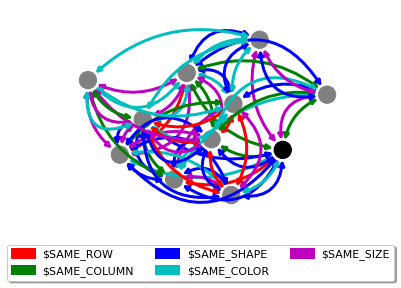

In [112]:
graph = ReaSCANGraph(
    objects=sampled_world["obj_map"], 
    object_patterns=sampled_world["obj_pattern_map"], 
    vocabulary=vocabulary,
    positions=sampled_world["pos_map"], 
    referred_object=sampled_world["referred_obj"],
    debug=False
)
graph.draw()

OrderedDict([(('$OBJ_0', 'square'), ['$SHAPE']), (('$OBJ_1', 'red'), ['$COLOR']), (('$OBJ_1', 'circle'), ['$SHAPE']), (('$OBJ_2', 'yellow'), ['$COLOR']), (('$OBJ_2', 'square'), ['$SHAPE']), (('$OBJ_0', '$OBJ_1'), ['$SAME_COLUMN']), (('$OBJ_1', '$OBJ_0'), ['$SAME_COLUMN']), (('$OBJ_0', '$OBJ_2'), ['$SAME_ROW']), (('$OBJ_2', '$OBJ_0'), ['$SAME_ROW'])])


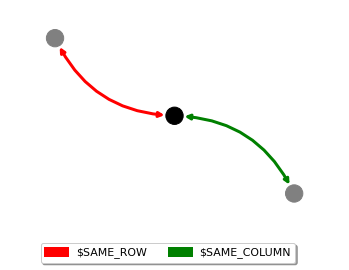

In [113]:
pattern_graph = ReaSCANGraph(
    objects=obj_map, 
    object_patterns=None,
    vocabulary=vocabulary,
    relations=rel_map, 
    referred_object='$OBJ_0', 
    debug=True
)
pattern_graph.draw()

[]
removing 133 edges ...


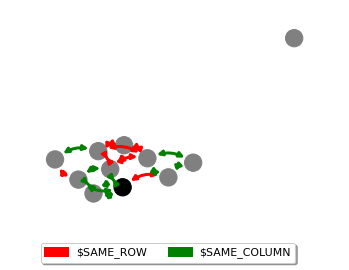

{'$OBJ_0'}

In [114]:
graph.find_referred_object(
    pattern_graph, referred_object='$OBJ_0', 
    debug=True
)

In [115]:
print("Command:")
command_str = grammer.repre_str_command(grammer_pattern, rel_map, obj_map)
print(f"walk to {command_str} cautiously")

Command:
walk to the square that is in the same column as the red circle and in the same row as the yellow square cautiously


In [22]:
import networkx as nx

class ReaSCANGraph(object):
    """
    SAME_ROW_REGEX = "$SAME_ROW"
    SAME_COL_REGEX = "$SAME_COLUMN"
    SAME_SHAPE_REGEX = "$SAME_SHAPE"
    SAME_COLOR_REGEX = "$SAME_COLOR"
    SAME_SIZE_REGEX = "$SAME_SIZE"
    IS_INSIDE_REGEX = "$IS_INSIDE"
    """

    def __init__(
        self, objects, object_patterns, vocabulary, 
        relations=None, positions=None, referred_object=None,
        debug=False
    ):
        self.vocabulary = vocabulary
        self.relations = OrderedDict({})
        self.G = nx.MultiDiGraph()
        self.G_full = nx.MultiDiGraph()
        if positions == None:
            # This means it is a abstract pattern, not a grounded shapeWorld graph.
            for obj_name, obj_str in objects.items():
                if referred_object != None and obj_name == referred_object:
                    self.G.add_node(obj_name, type="object", referent=True)
                    self.G_full.add_node(obj_name, type="object", referent=True)
                else:
                    self.G.add_node(obj_name, type="object", referent=False)
                    self.G_full.add_node(obj_name, type="object", referent=False)
                obj_str = obj_str.split(" ")
                if len(obj_str) == 1:
                    if obj_str[0] != "object":
                        self.relations[(obj_name, obj_str[0])] = ['$SHAPE']
                elif len(obj_str) == 2:
                    if obj_str[0] in vocabulary.get_size_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$SIZE']
                    elif obj_str[0] in vocabulary.get_color_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$COLOR']
                    if obj_str[1] != "object":
                        self.relations[(obj_name, obj_str[1])] = ['$SHAPE']
                elif len(obj_str) == 3:
                    if obj_str[0] in vocabulary.get_size_adjectives():
                        size = obj_str[0]
                    elif obj_str[0] in vocabulary.get_color_adjectives():
                        color = obj_str[0]
                    if obj_str[1] in vocabulary.get_size_adjectives():
                        size = obj_str[1]
                    elif obj_str[1] in vocabulary.get_color_adjectives():
                        color = obj_str[1]
                    composite_c_size = size + " " + color
                    self.relations[(obj_name,  composite_c_size)] = ['$SIZE_C'] # C_SIZE is sufficient.
                    if obj_str[2] != "object":
                        self.relations[(obj_name, obj_str[2])] = ['$SHAPE']
            for edge, relation in relations.items():
                src_node, dst_node = edge[0], edge[1]
                if (src_node, dst_node) not in self.relations:
                    self.relations[(src_node, dst_node)] = [relation]
                else:
                    self.relations[(src_node, dst_node)].append(relation)
                if relation != "$IS_INSIDE":
                    # permutable
                    dst_node, src_node = edge[0], edge[1]
                    if (src_node, dst_node) not in self.relations:
                        self.relations[(src_node, dst_node)] = [relation]
                    else:
                        self.relations[(src_node, dst_node)].append(relation)
            for edge, relations in self.relations.items(): 
                src_node, dst_node = edge[0], edge[1]
                for relation in relations:
                    if relation in ["$SAME_ROW", "$SAME_COLUMN", 
                                    "$SAME_SHAPE", "$SAME_COLOR", 
                                    "$SAME_SIZE", "$IS_INSIDE"]:
                        self.G.add_edge(src_node, dst_node, type=relation, key=relation)
                    self.G_full.add_edge(src_node, dst_node, type=relation, key=relation)
            if debug:
                print(self.relations)
        else:
            self.objects = objects
            self.positions = positions
            self.referred_object = referred_object
            relations = self.parse_relations(objects, object_patterns, positions)
            self.relations = relations
            if debug:
                print(self.relations)
            # formulate the graph
            for obj_name, obj in objects.items():
                if referred_object != None and obj_name == referred_object:
                    self.G.add_node(obj_name, type="object", referent=True)
                    self.G_full.add_node(obj_name, type="object", referent=True)
                else:
                    self.G.add_node(obj_name, type="object", referent=False)
                    self.G_full.add_node(obj_name, type="object", referent=False)
            for edge, relations in relations.items():
                src_node, dst_node = edge[0], edge[1]
                for relation in relations:
                    if relation in ["$SAME_ROW", "$SAME_COLUMN", 
                                    "$SAME_SHAPE", "$SAME_COLOR", 
                                    "$SAME_SIZE", "$IS_INSIDE"]:
                        self.G.add_edge(src_node, dst_node, type=relation, key=relation)
                    self.G_full.add_edge(src_node, dst_node, type=relation, key=relation)

        self.relation_color_map = {
            "$SAME_ROW" : "r",
            "$SAME_COLUMN" : "g",
            "$SAME_SHAPE" : "b",
            "$SAME_COLOR" : "c",
            "$SAME_SIZE" : "m",
            "$IS_INSIDE" : "y"
        }
        
    def draw(self, G_to_plot=None):
        """
        This function only draws objects and relations, but not attributes.
        """
        if G_to_plot == None:
            G = self.G
        else:
            G = G_to_plot

        color_map = []
        for node in G.nodes(data=True):
            if "referent" in node[1]:
                if node[1]["referent"]:
                    color_map.append('black')
                else:
                    color_map.append('grey')
            else:
                color_map.append('grey')
        edge_labels=dict(
            [((u,v,),d['type']) for u,v,d in G.edges(data=True)]
        )
            
        import matplotlib.pyplot as plt
        from matplotlib.legend_handler import HandlerTuple
        
        y_off = 0.5
        pos = nx.spring_layout(G)
        
        nx.draw_networkx_nodes(
            G, pos, node_color=color_map
        )

        ax = plt.gca()
        arrow_legend = []
        arrow_label = []
        node_connection_map = {}
        annotation_group_map = {
            "$SAME_ROW" : [],
            "$SAME_COLUMN" : [],
            "$SAME_SHAPE" : [],
            "$SAME_COLOR" : [],
            "$SAME_SIZE" : [],
            "$IS_INSIDE" : []
        }
        for e in G.edges(data=True):
            if ((e[0], e[1]) in node_connection_map and e[2]["type"] in node_connection_map[(e[0], e[1])]) or \
                ((e[1], e[0]) in node_connection_map and e[2]["type"] in node_connection_map[(e[1], e[0])]):
                continue # We draw using bidirectional arrows already!
            if (e[0], e[1]) not in node_connection_map:
                node_connection_map[(e[0], e[1])] = [e[2]["type"]]
            else:
                node_connection_map[(e[0], e[1])].append(e[2]["type"])
            connection_count = len(node_connection_map[(e[0], e[1])])
            if e[2]["type"] == "$IS_INSIDE":
                arrowstyle="<|-"
            else:
                arrowstyle="<|-|>"
            an = ax.annotate(
                "",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(
                    lw=3,
                    arrowstyle=arrowstyle, color=self.relation_color_map[e[2]["type"]],
                    shrinkA=10, shrinkB=10,
                    patchA=None, patchB=None,
                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*connection_count)),
                ),
                label = "a"
            )
            annotation_group_map[e[2]["type"]].append(an.arrow_patch)

        groups = []
        legends = []
        for type, group in annotation_group_map.items():
            if len(group) >= 1:
                groups.append(tuple([group[0]]))
                legends.append(type)
        plt.legend(groups, legends, numpoints=1, 
                   handler_map={tuple: HandlerTuple(ndivide=None)}, 
                   loc='upper center', bbox_to_anchor=(0.48, -0.06),
                   ncol=3, fancybox=True, shadow=True, fontsize=11)
        plt.margins(0.2)
        plt.axis('off')
        plt.show()

    def parse_relations(self, objects, object_patterns, positions):
        relations = OrderedDict({})
        
        # Attributes
        for obj_id, obj_spec in objects.items():
            # relations[(obj_id, obj_spec.size)] = "$SIZE"
            relations[(obj_id, obj_spec.color)] = ["$COLOR"]
            relations[(obj_id, obj_spec.shape)] = ["$SHAPE"]

            for to_obj_id, to_obj_spec in objects.items():
                if obj_id != to_obj_id:
                    # depending on the object pattern, we actually
                    # need to be certain on the attributes.
                    if to_obj_spec.shape == obj_spec.shape:
                        if obj_spec.size < to_obj_spec.size:
                            relations[(obj_id, "small")] = ["$SIZE"]
                        if obj_spec.size > to_obj_spec.size:
                            relations[(obj_id, "big")] = ["$SIZE"]
                    # If there is color and shape map, we need to add
                    # another set of edges other is color specific size edges.
                    if to_obj_spec.shape == obj_spec.shape and to_obj_spec.color == obj_spec.color:
                        if obj_spec.size < to_obj_spec.size:
                            relations[(obj_id, "small" + " " + obj_spec.color)] = ["$SIZE_C"]
                        if obj_spec.size > to_obj_spec.size:
                            relations[(obj_id, "big" + " " + obj_spec.color)] = ["$SIZE_C"]
        # Relations
        for obj_id_left, obj_spec_left in objects.items():
            for obj_id_right, obj_spec_right in objects.items():
                if obj_id_left != obj_id_right:
                    obj_pos_left = positions[obj_id_left]
                    obj_pos_right = positions[obj_id_right]
                    key = (obj_id_left, obj_id_right)
                    if obj_pos_left.row == obj_pos_right.row:
                        if key not in relations:
                            relations[key] = ["$SAME_ROW"]
                        else:
                            relations[key].append("$SAME_ROW")
                    if obj_pos_left.column == obj_pos_right.column:
                        if key not in relations:
                            relations[key] = ["$SAME_COLUMN"]
                        else:
                            relations[key].append("$SAME_COLUMN")
                    if obj_spec_left.size == obj_spec_right.size:
                        if key not in relations:
                            relations[key] = ["$SAME_SIZE"]
                        else:
                            relations[key].append("$SAME_SIZE")
                    if obj_spec_left.color == obj_spec_right.color:
                        if key not in relations:
                            relations[key] = ["$SAME_COLOR"]
                        else:
                            relations[key].append("$SAME_COLOR")
                    if obj_spec_left.shape == obj_spec_right.shape:
                        if key not in relations:
                            relations[key] = ["$SAME_SHAPE"]
                        else:
                            relations[key].append("$SAME_SHAPE")
                    # For IsInside relations.
                    if obj_spec_right.shape == "box":
                        if obj_pos_left.row >= obj_pos_right.row and \
                            obj_pos_left.row < obj_pos_right.row+obj_spec_right.size and \
                            obj_pos_left.column >= obj_pos_right.column and \
                            obj_pos_left.column < obj_pos_right.column+obj_spec_right.size:
                            if key not in relations:
                                relations[key] = ["$IS_INSIDE"]
                            else:
                                relations[key].append("$IS_INSIDE")
        return relations
    
    def find_referred_object(self, relation_pattern, referred_object="$OBJ_0", debug=False):
        from networkx.algorithms import isomorphism
        from networkx import DiGraph
        from networkx import line_graph
        G = self.G_full.copy()
        G_to_plot = self.G.copy()
        sub_G = relation_pattern.G_full.copy()

        # Major speed up!
        # We will remove irrelevant edges from G based on relations in sub_G
        sub_G_relations = set([])
        node_attr_count = {}
        for edge in sub_G.edges(data=True):
            if edge[2]["type"] in ["$SAME_ROW", "$SAME_COLUMN", 
                                   "$SAME_SHAPE", "$SAME_COLOR", 
                                   "$SAME_SIZE", "$IS_INSIDE"]:
                sub_G_relations.add(edge[2]["type"])
            else:
                sub_G_relations.add(edge[1] + " " + edge[2]["type"]) # attribute based!
                if edge[0] in node_attr_count.keys():
                    node_attr_count[edge[0]] += 1
                else:
                    node_attr_count[edge[0]] = 1
        to_remove_edges = []
        removed_edge_count = 0
        for edge in G.edges(data=True):
            if edge[2]["type"] in ["$SAME_ROW", "$SAME_COLUMN", 
                                   "$SAME_SHAPE", "$SAME_COLOR", 
                                   "$SAME_SIZE", "$IS_INSIDE"]:
                if edge[2]["type"] not in sub_G_relations:
                    to_remove_edges.append(edge)
            else:
                if edge[1] + " " + edge[2]["type"] not in sub_G_relations:
                    to_remove_edges.append(edge)
        for edge in to_remove_edges:
            if edge[2]["type"] in ["$SAME_ROW", "$SAME_COLUMN", 
                                   "$SAME_SHAPE", "$SAME_COLOR", 
                                   "$SAME_SIZE", "$IS_INSIDE"]:
                G_to_plot.remove_edge(edge[0], edge[1], key=edge[2]["type"])
            G.remove_edge(edge[0], edge[1], key=edge[2]["type"])
            removed_edge_count += 1
        # Go through again for deleting nodes.
        min_node_attr = 99
        for k, v in node_attr_count.items():
            if v < min_node_attr:
                min_node_attr = v
        to_remove_node_attr_count = {}
        for edge in G.edges(data=True):
            if edge[2]["type"] in ["$SAME_ROW", "$SAME_COLUMN", 
                                   "$SAME_SHAPE", "$SAME_COLOR", 
                                   "$SAME_SIZE", "$IS_INSIDE"]:
                pass
            else:
                if edge[0] in to_remove_node_attr_count.keys():
                    to_remove_node_attr_count[edge[0]] += 1
                else:
                    to_remove_node_attr_count[edge[0]] = 1
        to_remove_nodes = []
        for k, v in to_remove_node_attr_count.items():
            if v < min_node_attr:
                to_remove_nodes.append(k)
        # TODO: Remove node is not integrated yet!
        
        if debug:
            print(f"removing {removed_edge_count} edges ...")
            self.draw(G_to_plot=G_to_plot)
            
        line_G = line_graph(DiGraph(G))
        line_sub_G = line_graph(DiGraph(sub_G))
        
        DiGM = isomorphism.DiGraphMatcher(line_graph(DiGraph(G)), line_graph(DiGraph(sub_G)))
        
        valid_referred_nodes = []
        for edge_match in DiGM.subgraph_isomorphisms_iter():
            valid = True
            for G_pair, sub_G_pair in edge_match.items():
                # First pass: we can check naive node type. They need to match with each other.
                if G_pair[0].startswith("$") and G_pair[0][0] != sub_G_pair[0][0]:
                    valid = False
                    break # not valid.
                if G_pair[1].startswith("$") and G_pair[1][0] != sub_G_pair[1][0]:
                    valid = False
                    break # not valid.
                if not G_pair[1].startswith("$") and G_pair[1] != sub_G_pair[1]:
                    valid = False
                    break # not valid.
                # Second pass: if it is a edge between nodes, we need to match relations.
                if G_pair[0].startswith("$") and G_pair[1].startswith("$") and \
                    sub_G_pair[0].startswith("$") and sub_G_pair[1].startswith("$"):
                    # This is a relational pair.
                    overlap_relations = set(self.relations[G_pair]).intersection(
                        set(relation_pattern.relations[sub_G_pair])
                    )
                    if len(overlap_relations) == 0:
                        valid = False
                        break # not valid.
            if valid:
                pattern_node_map = {}
                for G_pair, sub_G_pair in edge_match.items():
                    if G_pair[0].startswith("$") and G_pair[1].startswith("$") and \
                        sub_G_pair[0].startswith("$") and sub_G_pair[1].startswith("$"):
                        if sub_G_pair[0] not in pattern_node_map:
                            pattern_node_map[sub_G_pair[0]] = G_pair[0]
                        else:
                            if pattern_node_map[sub_G_pair[0]] != G_pair[0]:
                                valid = False
                                break # not valid.
                        if sub_G_pair[1] not in pattern_node_map:
                            pattern_node_map[sub_G_pair[1]] = G_pair[1]
                        else:     
                            if pattern_node_map[sub_G_pair[1]] != G_pair[1]:
                                valid = False
                                break # not valid.
            
            if valid:
                valid_referred_nodes.append(pattern_node_map[referred_object])
        return set(valid_referred_nodes)

### ReaSCAN Dataset

In [15]:
class ReaSCAN(object):
    """
    This contains a couple modules:
    (1) dataset generator.
    (2) dataset splitter.
    (3) dataset stats monitor.
    (4) dataset IO operator.
    (5) dataset tensorer.
    """
    def __init__(self):
        pass